In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ==========================================================
# 0. Environment Setup
# ==========================================================
get_ipython().system('git clone https://github.com/Minxing-Zheng/CMU_10701_GroupProject.git')
get_ipython().run_line_magic('cd', 'CMU_10701_GroupProject')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

# 自己的模块
from models.lambdamart_ranker import LambdaMARTRanker, LambdaMARTConfig
from utils.split_utils import split_query_dict
from utils.fdp_eval import compute_fdp, find_lambda_hat

Cloning into 'CMU_10701_GroupProject'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 86 (delta 30), reused 67 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (86/86), 27.74 MiB | 24.43 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/CMU_10701_GroupProject/CMU_10701_GroupProject


In [4]:
# ==========================================================
# 1. 读取 Yahoo LTR (Set1) 数据
#    （你可以直接用之前那段 load_svmlight_with_qid 代码）
# ==========================================================
from scipy import sparse

def load_svmlight_with_qid(path):
    labels, qids, rows, cols, data = [], [], [], [], []
    max_f = 0
    with open(path, "r") as f:
        for r, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            y = float(parts[0]); labels.append(y)
            qtok = next((t for t in parts[1:] if t.startswith("qid:")), None)
            if qtok is None:
                raise ValueError(f"No qid token in line:\n{line[:80]}...")
            qids.append(int(qtok.split(":")[1]))
            for tok in parts[1:]:
                if tok.startswith("qid:"):
                    continue
                i, v = tok.split(":")
                c = int(i) - 1
                rows.append(r); cols.append(c); data.append(float(v))
                if c > max_f: max_f = c
    X = sparse.csr_matrix((data, (rows, cols)), shape=(len(labels), max_f+1), dtype=np.float32)
    y = np.asarray(labels, dtype=np.float32)
    q = np.asarray(qids, dtype=np.int64)
    return X, y, q

# 你可以把下面 ROOT 换成自己的路径，也可以把数据放到 repo 里
ROOT = "/content/drive/MyDrive/701_project/yahoo_ltr/ltrc_yahoo"
SET = "set1"
train_path = os.path.join(ROOT, f"{SET}.train.txt")
valid_path = os.path.join(ROOT, f"{SET}.valid.txt")
test_path  = os.path.join(ROOT, f"{SET}.test.txt")

X_tr, y_tr, q_tr = load_svmlight_with_qid(train_path)
X_vl, y_vl, q_vl = load_svmlight_with_qid(valid_path)
X_te, y_te, q_te = load_svmlight_with_qid(test_path)

print("Shapes — train:", X_tr.shape, "valid:", X_vl.shape, "test:", X_te.shape)

# LightGBM 不强制要求标准化，但为了和 MLP 版可比，这里统一做一下
scaler = StandardScaler(with_mean=False)  # sparse CSR => with_mean=False
X_tr_scaled = scaler.fit_transform(X_tr).toarray()
X_vl_scaled = scaler.transform(X_vl).toarray()
X_te_scaled = scaler.transform(X_te).toarray()

n_features = X_tr_scaled.shape[1]
print("Number of features:", n_features)


Shapes — train: (473134, 699) valid: (71083, 699) test: (165660, 699)
Number of features: 699


In [5]:
# ==========================================================
# 2. 简单的 LambdaMART 超参选择（在验证集上选最优 NDCG@10）
# ==========================================================

def ndcg_at_k(y_true, y_score, qid, k=10):
    """
    计算 mean NDCG@k over queries.
    """
    df = pd.DataFrame({
        "qid": qid,
        "label": y_true,
        "score": y_score,
    })
    ndcgs = []
    for q, g in df.groupby("qid"):
        g_sorted = g.sort_values("score", ascending=False)
        rel = g_sorted["label"].values
        # DCG@k
        topk = rel[:k]
        gains = (2 ** topk - 1)
        discounts = np.log2(np.arange(2, len(topk) + 2))
        dcg = (gains / discounts).sum()
        # IDCG@k
        ideal = np.sort(rel)[::-1][:k]
        gains_ideal = (2 ** ideal - 1)
        idcg = (gains_ideal / discounts).sum()
        if idcg > 0:
            ndcgs.append(dcg / idcg)
    return float(np.mean(ndcgs)) if ndcgs else 0.0


# 定义一个非常简易的超参网格
config_grid = [
    LambdaMARTConfig(num_leaves=31, learning_rate=0.05, n_estimators=300),
    LambdaMARTConfig(num_leaves=63, learning_rate=0.05, n_estimators=500),
    LambdaMARTConfig(num_leaves=63, learning_rate=0.1,  n_estimators=300),
]

best_config = None
best_ndcg = -1.0

for cfg in config_grid:
    print(f"=== Try config: num_leaves={cfg.num_leaves}, lr={cfg.learning_rate}, n_estimators={cfg.n_estimators} ===")
    ranker = LambdaMARTRanker(cfg)
    ranker.fit(X_tr_scaled, y_tr, q_tr)
    vl_scores = ranker.predict(X_vl_scaled)
    ndcg10 = ndcg_at_k(y_vl, vl_scores, q_vl, k=10)
    print(f"  -> valid NDCG@10 = {ndcg10:.4f}")
    if ndcg10 > best_ndcg:
        best_ndcg = ndcg10
        best_config = cfg

print("\nBest config:", best_config)
print("Best valid NDCG@10:", best_ndcg)

# 用 best config 在 train+valid 上重新训练
X_trvl = np.vstack([X_tr_scaled, X_vl_scaled])
y_trvl = np.concatenate([y_tr, y_vl])
q_trvl = np.concatenate([q_tr, q_vl])

best_ranker = LambdaMARTRanker(best_config)
best_ranker.fit(X_trvl, y_trvl, q_trvl)



=== Try config: num_leaves=31, lr=0.05, n_estimators=300 ===
  -> valid NDCG@10 = 0.7727
=== Try config: num_leaves=63, lr=0.05, n_estimators=500 ===
  -> valid NDCG@10 = 0.7774
=== Try config: num_leaves=63, lr=0.1, n_estimators=300 ===
  -> valid NDCG@10 = 0.7767

Best config: LambdaMARTConfig(num_leaves=63, learning_rate=0.05, n_estimators=500, subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, random_state=42, objective='lambdarank', metric='ndcg', ndcg_at=(5, 10))
Best valid NDCG@10: 0.7774107936030472


In [10]:
# ==========================================================
# 3. 在 test 上打分，生成 df_summary（和原 demo 一样格式）
# ==========================================================
test_scores = best_ranker.predict(X_te_scaled)

df_summary = pd.DataFrame({
    "qid": q_te,
    "doc_id": np.arange(len(q_te), dtype=np.int64),
    "label": y_te,
    "pred_score_raw": test_scores,  # 先留一个原始分数做参考
})

# 把 LambdaMART 分数过一遍 sigmoid，压到 [0,1]
df_summary["pred_score"] = 1 / (1 + np.exp(-df_summary["pred_score_raw"]))


df_summary.head()


,qid,doc_id,label,pred_score_raw,pred_score
0,22939,0,0.0,-0.840285,0.301475
1,22939,1,1.0,-1.128167,0.244499
2,22939,2,1.0,0.127966,0.531948
3,22939,3,0.0,-0.647680,0.343512
4,22939,4,0.0,-0.951719,0.278539


Mean NDCG@5  (test): 0.7181
Mean NDCG@10 (test): 0.7582


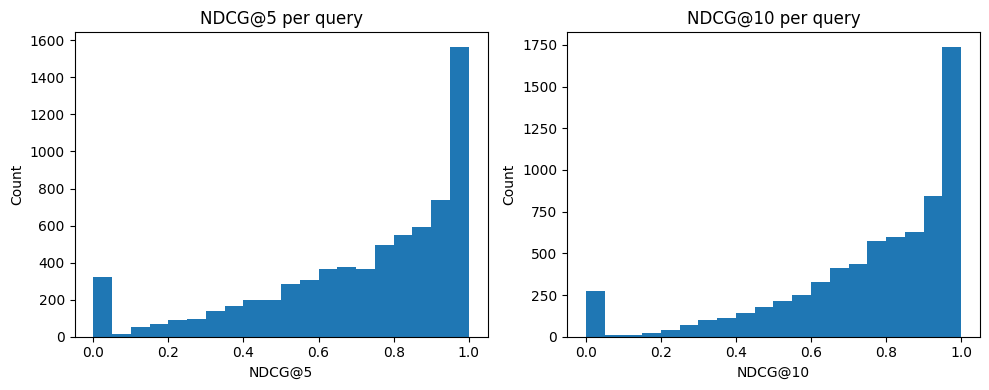

In [11]:
# ==========================================================
# 3.1 Ranking metrics: NDCG@5, NDCG@10 (per query)
# ==========================================================
def ndcg_at_k_per_query(df, k=10):
    """
    df: 包含 label, pred_score 的一个 query 下子表
    """
    g = df.sort_values("pred_score", ascending=False)
    rel = g["label"].values

    topk = rel[:k]
    gains = (2 ** topk - 1)
    discounts = np.log2(np.arange(2, len(topk) + 2))
    dcg = (gains / discounts).sum()

    ideal = np.sort(rel)[::-1][:k]
    gains_ideal = (2 ** ideal - 1)
    idcg = (gains_ideal / discounts).sum()

    if idcg == 0:
        return 0.0
    return float(dcg / idcg)

ndcg5_list = []
ndcg10_list = []

for q, g in df_summary.groupby("qid"):
    ndcg5_list.append(ndcg_at_k_per_query(g, k=5))
    ndcg10_list.append(ndcg_at_k_per_query(g, k=10))

print(f"Mean NDCG@5  (test): {np.mean(ndcg5_list):.4f}")
print(f"Mean NDCG@10 (test): {np.mean(ndcg10_list):.4f}")

# 可视化 NDCG 分布
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(ndcg5_list, bins=20)
axes[0].set_title("NDCG@5 per query")
axes[0].set_xlabel("NDCG@5")
axes[0].set_ylabel("Count")

axes[1].hist(ndcg10_list, bins=20)
axes[1].set_title("NDCG@10 per query")
axes[1].set_xlabel("NDCG@10")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [12]:

# ==========================================================
# 4. 转成 query_dict，拆 calib/test（完全复用原 demo）
# ==========================================================
query_dict = (
    df_summary.groupby("qid")[["doc_id", "label", "pred_score"]]
    .apply(lambda g: list(zip(g["doc_id"], g["label"], g["pred_score"])))
    .to_dict()
)
calib_dict_full, test_dict_full = split_query_dict(query_dict)
print(f"Number of calibration queries: {len(calib_dict_full)}")
print(f"Number of test queries:        {len(test_dict_full)}")

Number of calibration queries: 3237
Number of test queries:        3238


In [13]:
# ==========================================================
# 5. Compute FDP + λ̂ search（和原 demo 一样）
# ==========================================================
alpha = 0.3
delta = 0.1
lambda_step = 0.001
high_quality_threshold = 3

lambda_value = 0.50
fdp_per_qid, summary = compute_fdp(calib_dict_full, lambda_value, label_threshold=high_quality_threshold)
print(f"λ = {lambda_value:.3f}")
print(f"Empirical FDR: {summary['mean_fdp']:.4f}")

mean_fdr_list = []
mean_size_list = []
mean_true_list = []
lambda_list = []
success = []
n_exp = 100

for i in range(n_exp):
    cal, test = split_query_dict(query_dict, random_state=42 + i)
    lam = find_lambda_hat(cal, delta, alpha, lambda_step)
    lambda_list.append(lam)

    _, summary = compute_fdp(test, lam, high_quality_threshold)
    fdr = summary["mean_fdp"]

    mean_fdr_list.append(fdr)
    mean_size_list.append(summary["mean_selected"])
    mean_true_list.append(summary["mean_true"])
    success.append(fdr <= alpha)

    if (i + 1) % 20 == 0 or i == 0:
        print(f"[{i+1:03d}/{n_exp}]  λ̂={lam:.3f}   meanFDR={fdr:.3f}")

λ = 0.500
Empirical FDR: 0.6498
[001/100]  λ̂=0.765   meanFDR=0.256
[020/100]  λ̂=0.757   meanFDR=0.279
[040/100]  λ̂=0.758   meanFDR=0.276
[060/100]  λ̂=0.757   meanFDR=0.279
[080/100]  λ̂=0.752   meanFDR=0.300
[100/100]  λ̂=0.754   meanFDR=0.291


In [16]:
# ==========================================================
# 6. Summary & 7. Plot
# ==========================================================
p_hat = np.mean(success)
print("\n================== Conformal FDR Summary ==================")
print(f"α (target FDR):              {alpha}")
print(f"δ (tolerance):               {delta}")
print(f"Target:                      P(FDR ≤ α) ≥ 1-δ = {1-delta:.3f}")
print(f"Empirical:                   P̂ = {p_hat:.3f}")
print(f"Mean FDR:                    {np.mean(mean_fdr_list):.3f} ± {np.std(mean_fdr_list):.3f}")
print(f"Mean set size:               {np.mean(mean_size_list):.2f} ± {np.std(mean_size_list):.2f}")
print("============================================================")



================== Conformal FDR Summary ==================
α (target FDR):              0.3
δ (tolerance):               0.1
Target:                      P(FDR ≤ α) ≥ 1-δ = 0.900
Empirical:                   P̂ = 0.970
Mean FDR:                    0.282 ± 0.010
Mean set size:               1.69 ± 0.06


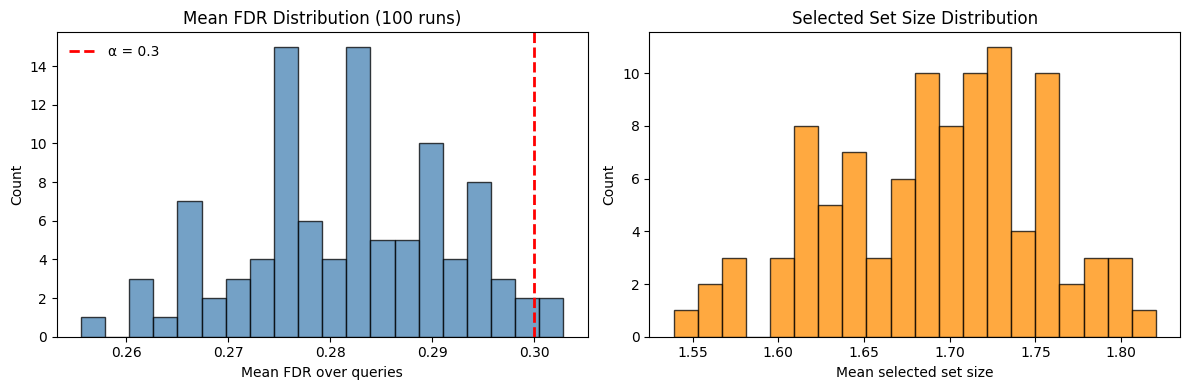

In [15]:



# -------------------------------------------------------------
# 7. Plots — Mean FDR and Set Size Distributions
# -------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- (a) Mean FDR Distribution ---
axes[0].hist(
    mean_fdr_list,
    bins=20,
    color="steelblue",
    alpha=0.75,
    edgecolor="black"
)
axes[0].axvline(alpha, color="red", linestyle="--", linewidth=2, label=f"α = {alpha}")
axes[0].set_xlabel("Mean FDR over queries")
axes[0].set_ylabel("Count")
axes[0].set_title(f"Mean FDR Distribution ({n_exp} runs)")
axes[0].legend(frameon=False)

# --- (b) Selected Set Size Distribution ---
axes[1].hist(
    mean_size_list,
    bins=20,
    color="darkorange",
    alpha=0.75,
    edgecolor="black"
)
axes[1].set_xlabel("Mean selected set size")
axes[1].set_ylabel("Count")
axes[1].set_title("Selected Set Size Distribution")

plt.tight_layout()
plt.show()
